In [4]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2.jl")
# working_dir = "C:\\Google Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan\\scan_3frequencies"
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\opt7"
;

In [5]:
"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = x[5]*Γ
    Δ4 = x[6]*Γ
    
    temp = @with_unit 0.5 "mK"
    diameter = @with_unit 0.6 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(
        t_end = 30e-3, n_values = 100,
        pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
        s1=s1, s2=0.0, s3=s3, s4=s4,
        Δ1=Δ1, Δ2=0.0, Δ3=Δ3, Δ4=Δ4,
        B_gradient=100,
        temp=temp, 
        diameter=diameter,
        displacement=displacement, 
        kick=kick,
        ramp_time=5e-3)
    
    results = simulate_particles_v2(package, params)
    
    return results
end
;

In [6]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(6,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(1, 1)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3, -3, -3, -5], [3, 3, 3, 3, 3, 3, 5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000)

opt = BOpt(f,
           model,
           UpperConfidenceBound(),                   # type of acquisition
           modeloptimizer,                        
           [0.0, 0.0, 0.0, +0.0, -2.0, +0.0],        # lowerbounds
           [5.0, 0.3, 0.3, +4.0, +0.0, +2.0],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 2000,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 5,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 1.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)
;

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = #MAPGPOptimizer#19 at gp.jl:37 [inlined]
└ @ Core C:\Users\halla\.julia\packages\BayesianOptimization\nq1HY\src\models\gp.jl:37


In [7]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

In [19]:
using Serialization
# opt_saved = deserialize("opt_3freq_test3.jl")
opt_saved = deserialize(working_dir * "\\opt_7param_save.jl")
;

In [20]:
opt.model = opt_saved.model
opt.lowerbounds = opt_saved.lowerbounds
opt.upperbounds = opt_saved.upperbounds
opt.observed_optimizer = opt_saved.observed_optimizer
opt.model_optimizer = opt_saved.model_optimizer
opt.observed_optimum = opt_saved.observed_optimum
opt.model_optimum = opt_saved.model_optimum
;

In [21]:
# maxiterations!(opt, 1)
# boptimize!(opt)

In [22]:
opt.lowerbounds

7-element Vector{Float64}:
  0.5
  0.5
  0.3
  0.5
  0.5
 -5.0
 10.0

In [23]:
opt.upperbounds

7-element Vector{Float64}:
  4.0
  4.0
  4.0
  4.0
  4.0
 -1.0
 50.0

In [24]:
opt.observed_optimizer

7-element Vector{Float64}:
  4.0
  4.0
  4.0
  4.0
  4.0
 -5.0
 27.630328075110285

In [26]:
opt.model_optimizer

7-element Vector{Float64}:
  4.0
  3.202032061325908
  3.2201165948119215
  4.0
  4.0
 -5.0
 19.101495806948073

In [29]:
opt.model_optimum

0.040920900714278056

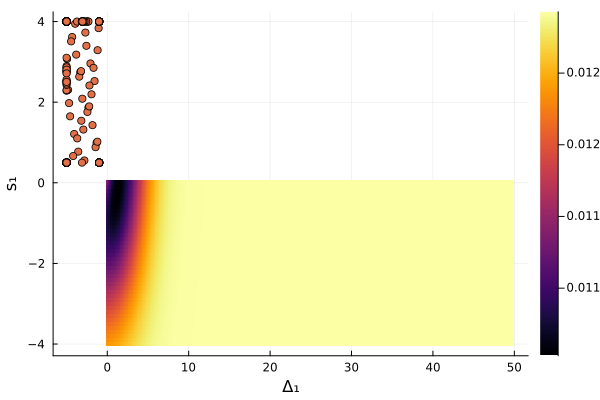

In [28]:
list1 = reverse(0:-0.1:-4.0)
list2 = 0:0.1:50.0

preds_mat = zeros(length(list1), length(list2))
points = zeros(7, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[5,1] = val1
        points[6,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list2, list1, preds_mat, xlabel="Δ₁", ylabel="s₁")
scatter!(opt.model.x[6,:], opt.model.x[5,:], legend=nothing)